In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch, ArrowStyle

## 1. Dataset

In [2]:
(train_ds, valid_ds, test_ds), fashion_mnist_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test[:50%]', 'test[50%:]'],
    as_supervised=True,
    with_info=True,
    shuffle_files=True)

datasets = {
    'train': train_ds,
    'valid': valid_ds,
    'test': test_ds
}

In [3]:
def preprocessing_pipeline(data):
    """Apply preproccesing pipeline to the given dataset.
    
    :param data: data to be preprocessed
    :type data: tensorflow 'Dataset'
    :return: preprocessed dataset
    :rtype: tensorflow 'Dataset'
    """
    # one-hot targets
    data = data.map(lambda image, target: (
        (tf.cast(image, tf.float32) / 127.5) - 1.0, #tf.reshape(inputs, [tf.size(inputs)]),
        tf.one_hot(int(target), 10)
    ))
    # normalize inputs tfrom range 0..255 to 0..1
    #data = data.map(lambda inputs, target:(
    #    tf.math.divide(inputs,128)-1,
    #    target
    #))
    # cache the dataset
    data = data.cache()
    # shuffle, batch and prefetch the dataset
    data = data.shuffle(1000)
    data = data.batch(32)
    data = data.prefetch(100)
    return data

Apply the preprocessing pipieline to every tensorflow dataset in the already existing datasets-dictonary.

In [4]:
datasets = {key:ds.apply(preprocessing_pipeline) for key, ds in datasets.items()}

## 2. Model

### 2.1 Model Class
Here we are essentially reusing our model class which we used over the last weeks.

In [5]:
class CustomModel(tf.keras.Model):
    """This is a custom model class
    
    :param loss_function: loss function used to calculate loss of the model
    :type loss_function: function from the tf.keras.losses module
    :param optimizer: optimizer used to apply gradients to the models
        trainable variables
    :type optimizer: function from the tf.keras.optimizers module
    :param layer_list: Contains all Layers of the model
    :type layer_list: list of CustomDense-Objects, optional
    """
    def __init__(self, loss_function, optimizer, layer_list):
        """Constructor function"""
        super(CustomModel, self).__init__()
        self.layer_list = layer_list
        self.loss_function = loss_function
        self.optimizer = optimizer

        

    def call(self, inputs):
        """Compute the feed-forward pass through all layers.
        
        :param inputs: network input
        :type inputs: tf.Tensor
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        tf.summary.histogram('outputs', x)
        return x
    
    def train_step(self, input, target):
        """Applys optimizer to all trainable variables of this model to
        minimize the loss (loss_function) between the target output and the
        predicted ouptut.

        :param input: input to the model
        :type input: tf.Tensor
        :param target: target output with repect to the input
        :type target: tf.Tensor
        :return: the loss and the accuracy of the models prediction
        :rtype: tuple of two floats
        """
        with tf.GradientTape() as tape:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            gradients = tape.gradient(loss, self.trainable_variables)
        # apply gradients to the trainable variables using a optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        accuracy = self.calc_accuracy(prediction, target)
        return loss, accuracy
    
    def test(self, test_data):
        """Calculate the mean loss and accuracy of the model over all elements
        of test_data.

        :param test_data: model is evaulated for test_data
        :type test_data: tensorflow 'Dataset'
        :return: mean loss and mean accuracy for all datapoints
        :rtype: tuple of two floats
        """
        # aggregator lists for tracking the loss and accuracy
        test_accuracy_agg = []
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for (input, target) in test_data:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            accuracy = self.calc_accuracy(prediction, target)
            # add loss and accuracy to aggregators
            test_loss_agg.append(loss.numpy())
            test_accuracy_agg.append(np.mean(accuracy))
        # calculate mean loss and accuracy
        test_loss = tf.reduce_mean(test_loss_agg)
        test_accuracy = tf.reduce_mean(test_accuracy_agg)
        return test_loss, test_accuracy
    
    def calc_accuracy(self, pred, target):
        """Calucalte accuracy between a prediction and a target.

        :param pred: a prediction that the model made
        :type pred: tf.Tensor of floats
        :param target: target that model should have predicted
        :type target: tf.Tensor of floats
        """
        same_prediction = np.argmax(target, axis=1) == np.argmax(pred, axis=1)
        return np.mean(same_prediction)

### 2.2 Initialize Model
We initialize a model that takes advantage of several convolutional layers. In contrast to Dense Layers, Convolutional Layers apply a number of kernels to their input. Every kernel/filter is mapped to the input with a step size specified by the argument 'stride'.

In this specific case we found the following architecture to result in the highest accuracy:


In [6]:
# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(0.001)
# Initialize Model
model = CustomModel(cross_entropy_loss, optimizer, layer_list=[
    tf.keras.layers.Conv2D(filters = 70, kernel_size=(3,3), strides = (1,1), padding = 'same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides = 2, padding='valid'),
    tf.keras.layers.Conv2D(filters = 100, kernel_size=(5,5), strides = (3,3), padding = 'same', activation=tf.nn.relu),
    # it is absolutely possible to use global average pooling here but as flattening also worked we used flattening here
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units = 80, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 10, activation = tf.nn.softmax)])
# Build model to output it's summary
model.build(input_shape=(None, 28, 28, 1))
model.summary()


Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  700       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  175100    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  200080    
                                                                 
 dense_1 (Dense)             multiple                  810       
                                                      

### 2.1 Model's Receptive Field

Compute the receptive field size for the last convolutional layer of our model. This value tells us how many pixels/features from the input image influence a pixel/feature from the last conv-layer.\
**Closed-form expression for the receptive field size:**\
$\sum_{l=1}^{L} \bigg((k_l-1)\prod_{i=1}^{l-1} s_i\bigg)+1$










In [7]:
# Calucalte the receptive field of the final convolutional layer in our model
receptive_field = 1
for l, layer in enumerate(model.layer_list):
    # check that we are working with a convolutional layer
    if type(layer) is tf.keras.layers.Conv2D:
        k_l = layer.kernel_size[0] - 1
    elif type(layer) is tf.keras.layers.MaxPooling2D or type(layer) is tf.keras.layers.AveragePooling2D:
        k_l = layer.pool_size[0] -1
    else:
        # stop layer-traverse if a non convolutional layer was reached
        last_conv_layer_index = l - 1
        break
    # multiply strides of all layers before the current layer
    prod = np.prod([x.strides[0] for x in model.layer_list[:l]])
    receptive_field += k_l * prod        

print("Receptive Field:", int(receptive_field))

Receptive Field: 13



Next it would be interesting to know the coordiates of a receptive field region in the input image. This allows us to see which exact pixels influence a specific feature in the last conv-layer.\
**Iterative formula for the receptive field region:**\
$u_l$ and $v_l$ - denote the two diagonally opposite coodinates of the region that is used to calculate a feature in the next layer. This formula is applied iteratively by going backwards through the convolutional/(max/average)-pooling layers.\
$p_l$ - denotes a layers padding (value depends on the layers kernel size)\
$s_l$ - denotes layers stride-size\
$k_l$ - denotes layers kernel-size\
$u_{l-1}=-p_l+u_l*s_l$\
$v_{l-1}=-p_l+v_l*s_l+k_l-1$

In [8]:
def receptive_field_region(model, start_layer_index, end_layer_index, coords):
    """Compute the receptive field region coordiantes for the start-layer with
    respect to the end-layer.

    :param model: model that contains the layer_list
    :type model: object of class CustomClass
    :param start_layer_index: layer at which backwards-progagation of the
        formula is started.
    :type start_layer_index: integer
    :param end_layer_index: layer at which to stop iteration. Function returns
        region that the end_layer extracts from its input
    :type end_layer_index: integer
    :param coords: coordinate in start_layer for which to compute the receptive
        field region
    :type coords: numpy.array of 2 elements
    :return: 2 coordinates denoting two diagonal opposing corners of the
        receptive field region
    :rtype: tuple of two numpy arrays
    """
    # Computing receptive field region in input image
    # u_l and v_l corresponds to the location of the feature for which the rf-region
    # should be computed
    u_layer = coords
    v_layer = u_layer
    # iterate backwards through layers - starting at the last convolutional layer
    for layer in model.layer_list[end_layer_index:start_layer_index][::-1]:
        layer_kernel = layer.kernel_size if type(layer) is tf.keras.layers.Conv2D else layer.pool_size
        layer_padding = np.array([0,0]) if layer.padding == 'valid' else np.array(layer_kernel) // 2
        layer_stride = layer.strides
        u_layer = - layer_padding + u_layer * layer_stride
        v_layer = - layer_padding + v_layer * layer_stride + layer_kernel - 1
    return u_layer, v_layer

Following a function was implemented to visualize the receptive field region in each convolutional layer. This allows us to understand the flow of information better and to tweak our network, i.e the reception field region of the outputs should cover a large part of the input.

In [9]:
def visualize_receptive_region(model, last_conv_layer_index, coord):
    """Visualize the perceptive field for a neuron of last convolutional layer
    in the provided model.

    :param model: model that contains the layer_list
    :type model: object of class CustomClass
    :param last_conv_layer_index: index of the last convolutional layer in the
        network.
    :type last_conv_layer_index: integer
    :param coord: coordinates in the last layer for which to compute and
        visualize the receptive field.
    :type coord: list of two integers denoting x and y
    """
    feature_shape = np.array([28, 28])
    fig, axs = plt.subplots(1,last_conv_layer_index+2)
    fig.set_size_inches(30,5.5)
    fig.suptitle("'Output Shapes' and Receptive Regions of the Conv- and Pool-Layers (filters not shown)",
                weight='bold', size=19)
    axs[0].set_title('Input', weight='bold')
    axs[0].tick_params(bottom=False, labelbottom=False,left=False, labelleft=False)
    axs[0].set_facecolor((0.2, 0.2, 0.2,0.8))
    axs[0].set_aspect('equal')
    for image, _ in datasets['train'].take(1):
        axs[0].imshow(image[0,:,:,0], cmap='gray')
    
    # display green dots for every pixel in the image
    axs[0].scatter(x=[i for i in range(feature_shape[0]) for _ in range(feature_shape[1])],
                y=[i for _ in range(feature_shape[0]) for i in range(feature_shape[1])],
                s=3, c='lime')

    # compute and visualize receptive field region in input image
    start_rr, end_rr = receptive_field_region(model, last_conv_layer_index+1,0, np.array(coord))
    if model.layer_list[1].padding == 'valid':
            start_rr = np.clip(start_rr, 0, feature_shape[0]-1)
            end_rr = np.clip(end_rr, 0, feature_shape[0]-1)
    axs[0].scatter(x=np.arange(start_rr[0], end_rr[0]+1).repeat(end_rr[1]-start_rr[1]+1),
                   y=np.tile(np.arange(start_rr[1], end_rr[1]+1), end_rr[0] - start_rr[0]+1),
                   s=7, c='r')

    # list containing information about the layer-output-shape and its name
    layers_info = []        
    for i, layer in enumerate(model.layer_list[:last_conv_layer_index+1], 1):
        if type(layer) is tf.keras.layers.Conv2D:
            feature_shape -= (layer.kernel_size[0]//2)*2 if layer.padding == 'valid' else 0
        else:
            feature_shape -= (layer.pool_size[0]//2)*2 if layer.padding == 'valid' else 0
        feature_shape = (feature_shape/layer.strides[0]).astype(int)
        layer_name = str(type(layer))
        layer_name = layer_name[layer_name.rfind('.')+1:layer_name.rfind("'")]
        layers_info.append({'shape-out': feature_shape,
                            'name': layer_name})
    
    # iterate through layers_info to visualize receptive field region
    for i, info in enumerate(layers_info, 1):
        axs[i].set_title(f"{info['name']} - Layer {i}", weight='bold')
        axs[i].tick_params(bottom=False, labelbottom=False,left=False, labelleft=False)
        axs[i].set_facecolor((0.2, 0.2, 0.2,0.8))
        axs[i].set_aspect('equal')
        axs[i].set_adjustable('box')
        axs[i].invert_yaxis()
        # display dots for every output feature of the current layer
        axs[i].scatter(x=[j for j in range(info['shape-out'][0]) for _ in range(info['shape-out'][1])],
                       y=[j for _ in range(info['shape-out'][0]) for j in range(info['shape-out'][1])],
                       s=3, c='lime')
        # compute and visualize reciptive field in current layers output
        start_rr, end_rr = receptive_field_region(model, last_conv_layer_index+1, i, np.array(coord))
        if i<len(layers_info) and model.layer_list[i].padding == 'valid':
            start_rr = np.clip(start_rr, 0, info['shape-out'][0]-1)
            end_rr = np.clip(end_rr, 0, info['shape-out'][0]-1)
        axs[i].scatter(x=np.arange(start_rr[0], end_rr[0]+1).repeat(end_rr[1]-start_rr[1]+1),
                       y=np.tile(np.arange(start_rr[1], end_rr[1]+1), end_rr[0] - start_rr[0]+1),
                       s=7, c='r')
        # create arrow
        con = ConnectionPatch(
            xyA=(max(axs[i-1].get_xlim()), sum(axs[i-1].get_ylim()) / 2),
            xyB=(0, sum(axs[i].get_ylim())/2),
            coordsA='data', coordsB='data',
            axesA=axs[i-1], axesB=axs[i],
            color='r', lw=3,
            arrowstyle=ArrowStyle.CurveB(head_length=0.9, head_width=0.4))
        axs[i-1].add_artist(con)

    plt.show()

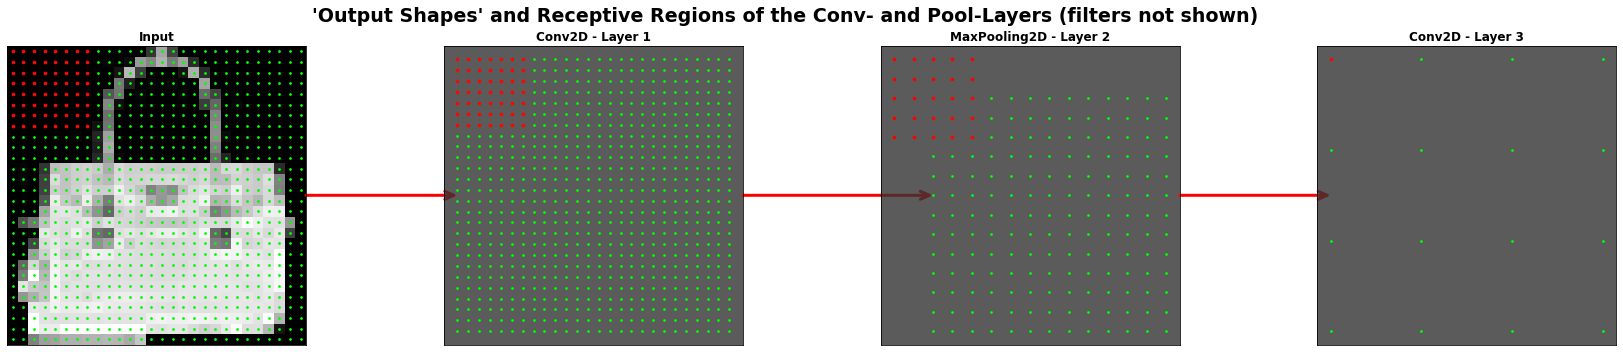

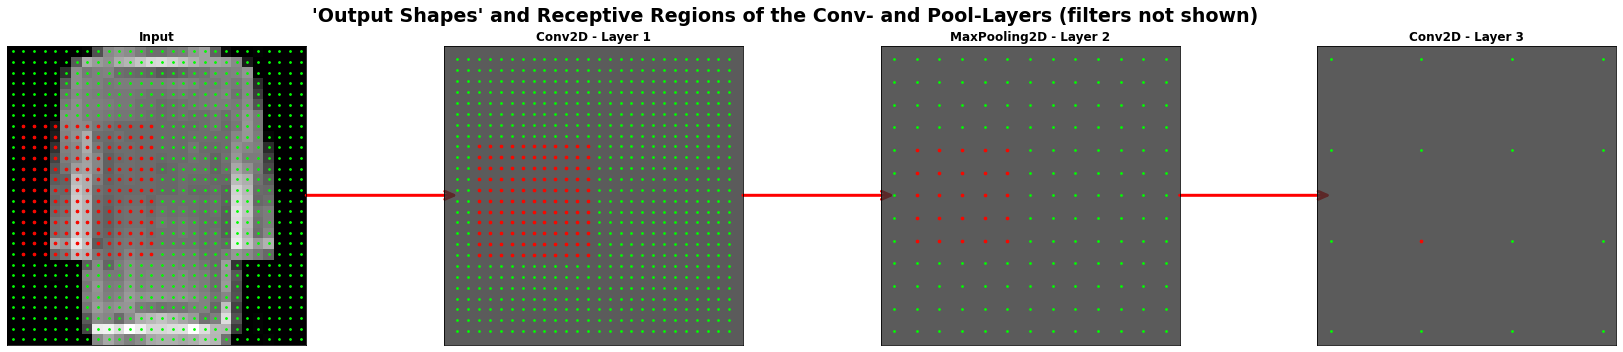

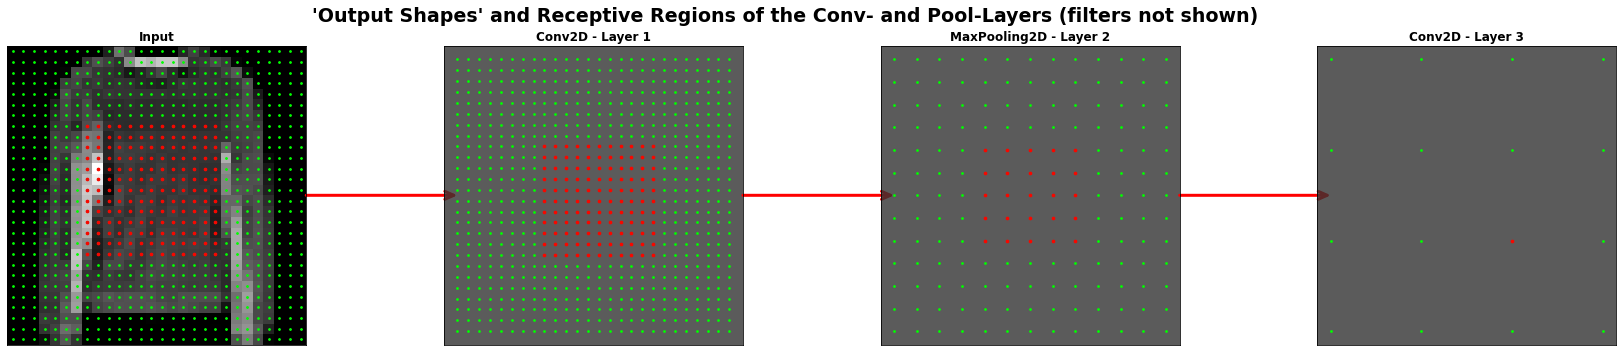

In [10]:
visualize_receptive_region(model, last_conv_layer_index, [0,0])
visualize_receptive_region(model, last_conv_layer_index, [1,2])
visualize_receptive_region(model, last_conv_layer_index, [2,2])

## 3. Training Model

In [11]:
def training(input_model, datasets, epochs=10):
    """Training a model on a dataset for a certain amount of epochs.

    :param input_model: model to be trained
    :type input_model: model of type CustomModel
    :param datasets: train, validation and test datasets
    :type datasets: dictionary containing tf datasets keyed with: 'train',
        'test', 'valid'
    :param epochs: number of epochs to train on the dataset
    :type epochs: integer
    :return: losses and accuracies
    :rtype: tuple containing two dictonaries for the losses and accuracies.
        These are keyed like the dataset with 'train', 'valid' and 'test'
    """
    tf.keras.backend.clear_session()
    # Initialize lists for tracking loss and accuracy
    losses = {'train':[], 'valid':[], 'test':0}
    accuracies = {'train':[], 'valid':[], 'test':0}
        
    # Train-Dataset
    train_loss, train_accuracy = input_model.test(datasets['train'])

    losses['train'].append(train_loss)
    accuracies['train'].append(train_accuracy)

    valid_loss, valid_accuracy = input_model.test(datasets['valid'])
    #valid_losses.append(valid_loss)
    #valid_accuracies.append(valid_accuracy)
    losses['valid'].append(valid_loss)
    accuracies['valid'].append(valid_accuracy)

    # Training for epochs
    for epoch in range(1, epochs+1):
        last_valid_acc = np.round(accuracies['valid'][-1], 3)
        print(f'Epoch {str(epoch)} starting with validation accuracy of {last_valid_acc}')
        epoch_loss_agg = []
        epoch_accuracy_agg = []
        for input, target in datasets['train']:
            train_loss, train_accuracy = input_model.train_step(input, target)
            epoch_loss_agg.append(train_loss)
            epoch_accuracy_agg.append(train_accuracy)
        # track training loss and accuracy
        losses['train'].append(tf.reduce_mean(epoch_loss_agg))
        accuracies['train'].append(tf.reduce_mean(epoch_accuracy_agg))
        # track loss and accuracy for test-dataset
        valid_loss, valid_accuracy = input_model.test(datasets['valid'])
        losses['valid'].append(valid_loss)
        accuracies['valid'].append(valid_accuracy)
    test_loss, test_accuracy = input_model.test(datasets['test'])

    losses['test'] = test_loss
    accuracies['test'] = test_accuracy    

    return losses, accuracies

In [12]:
losses, accuracies = training(model, datasets, epochs=10)

Epoch 1 starting with validation accuracy of 0.075
Epoch 2 starting with validation accuracy of 0.89
Epoch 3 starting with validation accuracy of 0.905
Epoch 4 starting with validation accuracy of 0.914
Epoch 5 starting with validation accuracy of 0.911
Epoch 6 starting with validation accuracy of 0.908
Epoch 7 starting with validation accuracy of 0.915
Epoch 8 starting with validation accuracy of 0.917
Epoch 9 starting with validation accuracy of 0.92
Epoch 10 starting with validation accuracy of 0.921


### 4. Visualization

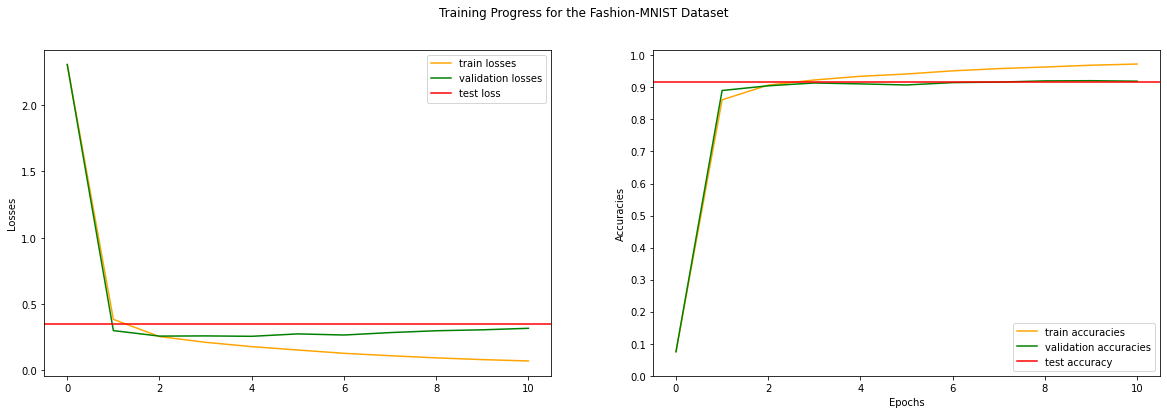

In [13]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

fig.suptitle('Training Progress for the Fashion-MNIST Dataset')
axs[0].plot(losses['train'], color='orange', label='train losses')
axs[0].plot(losses['valid'], color='green', label='validation losses')
axs[0].axhline(y=losses['test'], color='r', linestyle='-', label='test loss')
axs[0].set(ylabel='Losses')
axs[0].legend()
axs[1].plot(accuracies['train'], color='orange', label='train accuracies')
axs[1].plot(accuracies['valid'], color='green', label='validation accuracies')
axs[1].axhline(y=accuracies['test'], color='r', linestyle='-', label='test accuracy')
axs[1].set_yticks(np.arange(0,1.1,0.1))
axs[1].set(xlabel='Epochs', ylabel='Accuracies')
axs[1].legend()